# 17. Sliding Window 5-Fold CV Model Comparison

## Key Changes from Notebook 13
1. **Data**: Using sliding window dataset (13,514 samples vs 6,056)
2. **CV Strategy**: StratifiedGroupKFold (group by patient_id)
3. **Prevents Data Leakage**: Same patient never in both train and test

## Reference
- Taiwan MJ 2024 (PLoS ONE): Used similar sliding window approach

## Date: 2026-01-12

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_auc_score, recall_score, precision_score, f1_score,
    balanced_accuracy_score, confusion_matrix, roc_curve
)
import xgboost as xgb
from scipy import stats

# Set font
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("Packages loaded successfully")

Packages loaded successfully


In [2]:
# Load sliding window data
df = pd.read_csv('../../data/01_primary/SUA/processed/SUA_sliding_window.csv')
print(f"Data loaded: {len(df):,} samples from {df['patient_id'].nunique():,} patients")
print(f"Average samples per patient: {len(df) / df['patient_id'].nunique():.2f}")
print(f"\nColumns: {list(df.columns)}")

Data loaded: 13,514 samples from 6,056 patients
Average samples per patient: 2.23

Columns: ['patient_id', 'window_start', 'window_id', 'sex', 'Age', 'FBG_Tinput1', 'TC_Tinput1', 'Cr_Tinput1', 'UA_Tinput1', 'GFR_Tinput1', 'BMI_Tinput1', 'SBP_Tinput1', 'DBP_Tinput1', 'FBG_Tinput2', 'TC_Tinput2', 'Cr_Tinput2', 'UA_Tinput2', 'GFR_Tinput2', 'BMI_Tinput2', 'SBP_Tinput2', 'DBP_Tinput2', 'Delta_FBG', 'Delta_TC', 'Delta_Cr', 'Delta_UA', 'Delta_GFR', 'Delta_BMI', 'Delta_SBP', 'Delta_DBP', 'hypertension_target', 'hyperglycemia_target', 'dyslipidemia_target']


In [3]:
# Check window distribution
print("Window start distribution:")
print(df['window_start'].value_counts().sort_index())

Window start distribution:
1    6056
2    4302
3    2526
4     591
5      35
6       4
Name: window_start, dtype: int64


In [4]:
# Define features and targets
feature_cols = [
    'sex', 'Age',
    # Tinput1 features
    'FBG_Tinput1', 'TC_Tinput1', 'Cr_Tinput1', 'UA_Tinput1', 'GFR_Tinput1', 'BMI_Tinput1', 'SBP_Tinput1', 'DBP_Tinput1',
    # Tinput2 features
    'FBG_Tinput2', 'TC_Tinput2', 'Cr_Tinput2', 'UA_Tinput2', 'GFR_Tinput2', 'BMI_Tinput2', 'SBP_Tinput2', 'DBP_Tinput2',
    # Delta features
    'Delta_FBG', 'Delta_TC', 'Delta_Cr', 'Delta_UA', 'Delta_GFR', 'Delta_BMI', 'Delta_SBP', 'Delta_DBP'
]

target_cols = {
    'Hypertension': 'hypertension_target',
    'Hyperglycemia': 'hyperglycemia_target',
    'Dyslipidemia': 'dyslipidemia_target'
}

# Groups for GroupKFold
groups = df['patient_id']

X = df[feature_cols].copy()

# Convert targets: 1=normal, 2=disease -> 0=normal, 1=disease
targets = {}
for name, col in target_cols.items():
    targets[name] = (df[col] == 2).astype(int)

print("="*60)
print("Feature Info")
print("="*60)
print(f"Total features: {len(feature_cols)}")
print(f"  - Demographics: 2")
print(f"  - Tinput1: 8")
print(f"  - Tinput2: 8")
print(f"  - Delta: 8")

print("\n" + "="*60)
print("Class Imbalance (Sliding Window Data)")
print("="*60)
for name, y in targets.items():
    pos_rate = y.mean() * 100
    neg_count = (y == 0).sum()
    pos_count = (y == 1).sum()
    ratio = neg_count / pos_count if pos_count > 0 else float('inf')
    print(f"{name}: {pos_rate:.2f}% prevalence (neg:pos = {ratio:.1f}:1)")

Feature Info
Total features: 26
  - Demographics: 2
  - Tinput1: 8
  - Tinput2: 8
  - Delta: 8

Class Imbalance (Sliding Window Data)
Hypertension: 19.29% prevalence (neg:pos = 4.2:1)
Hyperglycemia: 5.93% prevalence (neg:pos = 15.9:1)
Dyslipidemia: 7.94% prevalence (neg:pos = 11.6:1)


In [5]:
# Define models (same as notebook 13)
def get_models(random_state=42):
    return {
        'LR': LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=random_state
        ),
        'DT': DecisionTreeClassifier(
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=random_state
        ),
        'RF': RandomForestClassifier(
            n_estimators=100,
            max_depth=15,
            min_samples_split=10,
            class_weight='balanced',
            random_state=random_state,
            n_jobs=-1
        ),
        'XGB': xgb.XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            scale_pos_weight=5,
            random_state=random_state,
            eval_metric='logloss',
            verbosity=0
        ),
        'SVM': SVC(
            kernel='rbf',
            class_weight='balanced',
            probability=True,
            random_state=random_state
        ),
        'MLP': MLPClassifier(
            hidden_layer_sizes=(64, 32, 16),
            activation='relu',
            solver='adam',
            learning_rate_init=0.001,
            max_iter=500,
            random_state=random_state,
            early_stopping=True,
            validation_fraction=0.1
        )
    }

print("Models defined:")
for name in get_models().keys():
    print(f"  - {name}")

Models defined:
  - LR
  - DT
  - RF
  - XGB
  - SVM
  - MLP


In [6]:
def evaluate_model_cv_grouped(X, y, groups, model, n_splits=5, random_state=42):
    """
    Evaluate model using StratifiedGroupKFold.
    
    Key difference from notebook 13:
    - Uses groups (patient_id) to ensure no data leakage
    - Same patient never appears in both train and test
    """
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    fold_metrics = {
        'auc': [], 'sensitivity': [], 'specificity': [],
        'f1': [], 'balanced_acc': [], 'y_true': [], 'y_prob': []
    }
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y, groups)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Verify no data leakage
        train_patients = set(groups.iloc[train_idx])
        test_patients = set(groups.iloc[test_idx])
        assert len(train_patients & test_patients) == 0, f"Data leakage in fold {fold}!"
        
        # Standardize
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Clone model
        from sklearn.base import clone
        model_clone = clone(model)
        
        # Adjust XGBoost
        if hasattr(model_clone, 'scale_pos_weight'):
            scale = (y_train == 0).sum() / (y_train == 1).sum()
            model_clone.set_params(scale_pos_weight=scale)
        
        # Train
        model_clone.fit(X_train_scaled, y_train)
        
        # Predict
        y_prob = model_clone.predict_proba(X_test_scaled)[:, 1]
        y_pred = model_clone.predict(X_test_scaled)
        
        # Metrics
        fold_metrics['auc'].append(roc_auc_score(y_test, y_prob))
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fold_metrics['sensitivity'].append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        fold_metrics['specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)
        fold_metrics['f1'].append(f1_score(y_test, y_pred, zero_division=0))
        fold_metrics['balanced_acc'].append(balanced_accuracy_score(y_test, y_pred))
        
        fold_metrics['y_true'].extend(y_test.tolist())
        fold_metrics['y_prob'].extend(y_prob.tolist())
    
    # Summary
    result = {}
    for metric in ['auc', 'sensitivity', 'specificity', 'f1', 'balanced_acc']:
        values = fold_metrics[metric]
        result[f'{metric}_mean'] = np.mean(values)
        result[f'{metric}_std'] = np.std(values)
        result[f'{metric}_folds'] = values
        
        ci = stats.t.interval(0.95, len(values)-1, loc=np.mean(values), scale=stats.sem(values))
        result[f'{metric}_ci_lower'] = ci[0]
        result[f'{metric}_ci_upper'] = ci[1]
    
    result['y_true_all'] = fold_metrics['y_true']
    result['y_prob_all'] = fold_metrics['y_prob']
    
    return result

print("Evaluation function defined (with GroupKFold)")

Evaluation function defined (with GroupKFold)


In [7]:
# Run 5-fold CV with GroupKFold
print("="*80)
print("Running 5-Fold CV with StratifiedGroupKFold")
print("(No data leakage: same patient never in train and test)")
print("="*80)

all_results = []
detailed_results = {}

for disease_name, y in targets.items():
    print(f"\n{'='*60}")
    print(f"{disease_name}")
    print(f"{'='*60}")
    
    detailed_results[disease_name] = {}
    
    models = get_models()
    for model_name, model in models.items():
        print(f"  Training {model_name}...", end=" ")
        
        result = evaluate_model_cv_grouped(X, y, groups, model)
        detailed_results[disease_name][model_name] = result
        
        all_results.append({
            'Disease': disease_name,
            'Model': model_name,
            'AUC': result['auc_mean'],
            'AUC_std': result['auc_std'],
            'AUC_CI': f"({result['auc_ci_lower']:.3f}, {result['auc_ci_upper']:.3f})",
            'Sensitivity': result['sensitivity_mean'],
            'Specificity': result['specificity_mean'],
            'F1': result['f1_mean'],
            'Balanced_Acc': result['balanced_acc_mean']
        })
        
        print(f"AUC = {result['auc_mean']:.3f} +/- {result['auc_std']:.3f}")

results_df = pd.DataFrame(all_results)
print("\n5-Fold CV (GroupKFold) completed!")

Running 5-Fold CV with StratifiedGroupKFold
(No data leakage: same patient never in train and test)

Hypertension
  Training LR... AUC = 0.721 +/- 0.017
  Training DT... AUC = 0.658 +/- 0.012
  Training RF... AUC = 0.743 +/- 0.013
  Training XGB... AUC = 0.738 +/- 0.012
  Training SVM... AUC = 0.726 +/- 0.011
  Training MLP... AUC = 0.703 +/- 0.033

Hyperglycemia
  Training LR... AUC = 0.938 +/- 0.010
  Training DT... AUC = 0.835 +/- 0.014
  Training RF... AUC = 0.932 +/- 0.008
  Training XGB... AUC = 0.930 +/- 0.014
  Training SVM... AUC = 0.919 +/- 0.012
  Training MLP... AUC = 0.919 +/- 0.021

Dyslipidemia
  Training LR... AUC = 0.867 +/- 0.012
  Training DT... AUC = 0.744 +/- 0.037
  Training RF... AUC = 0.859 +/- 0.014
  Training XGB... AUC = 0.857 +/- 0.016
  Training SVM... AUC = 0.845 +/- 0.012
  Training MLP... AUC = 0.742 +/- 0.136

5-Fold CV (GroupKFold) completed!


In [8]:
# Display results
print("="*100)
print("5-Fold CV Results (Sliding Window + GroupKFold)")
print("="*100)

for disease in targets.keys():
    print(f"\n--- {disease} ---")
    disease_df = results_df[results_df['Disease'] == disease].copy()
    disease_df = disease_df.sort_values('AUC', ascending=False)
    
    display_df = disease_df[['Model', 'AUC', 'AUC_std', 'AUC_CI', 
                             'Sensitivity', 'Specificity', 'F1', 'Balanced_Acc']].copy()
    display_df = display_df.round(3)
    print(display_df.to_string(index=False))

5-Fold CV Results (Sliding Window + GroupKFold)

--- Hypertension ---
Model   AUC  AUC_std         AUC_CI  Sensitivity  Specificity    F1  Balanced_Acc
   RF 0.743    0.013 (0.725, 0.762)        0.286        0.890 0.328         0.588
  XGB 0.738    0.012 (0.722, 0.755)        0.678        0.676 0.447         0.677
  SVM 0.726    0.011 (0.711, 0.742)        0.704        0.635 0.436         0.670
   LR 0.721    0.017 (0.697, 0.744)        0.697        0.638 0.434         0.668
  MLP 0.703    0.033 (0.657, 0.749)        0.017        0.996 0.032         0.506
   DT 0.658    0.012 (0.641, 0.675)        0.646        0.629 0.404         0.638

--- Hyperglycemia ---
Model   AUC  AUC_std         AUC_CI  Sensitivity  Specificity    F1  Balanced_Acc
   LR 0.938    0.010 (0.924, 0.951)        0.858        0.882 0.461         0.870
   RF 0.932    0.008 (0.921, 0.943)        0.551        0.965 0.525         0.758
  XGB 0.930    0.014 (0.911, 0.949)        0.745        0.933 0.532         0.839
  SVM

In [9]:
# Compare with original (non-sliding window) results
print("="*80)
print("Comparison: Sliding Window vs Fixed Window")
print("="*80)

# Original results from notebook 13 (hardcoded for comparison)
original_results = {
    'Hypertension': {'LR': 0.754, 'RF': 0.791, 'XGB': 0.789},
    'Hyperglycemia': {'LR': 0.932, 'RF': 0.930, 'XGB': 0.918},
    'Dyslipidemia': {'LR': 0.867, 'RF': 0.857, 'XGB': 0.857}
}

print("\n| Disease | Model | Fixed Window | Sliding Window | Diff |")
print("|---------|-------|-------------|----------------|------|")

for disease in targets.keys():
    for model in ['LR', 'RF', 'XGB']:
        orig = original_results[disease].get(model, '-')
        new_row = results_df[(results_df['Disease'] == disease) & (results_df['Model'] == model)]
        if len(new_row) > 0:
            new = new_row['AUC'].values[0]
            diff = new - orig if isinstance(orig, float) else '-'
            diff_str = f"{diff:+.3f}" if isinstance(diff, float) else diff
            print(f"| {disease:12} | {model:5} | {orig:.3f} | {new:.3f} | {diff_str} |")

Comparison: Sliding Window vs Fixed Window

| Disease | Model | Fixed Window | Sliding Window | Diff |
|---------|-------|-------------|----------------|------|
| Hypertension | LR    | 0.754 | 0.721 | -0.033 |
| Hypertension | RF    | 0.791 | 0.743 | -0.048 |
| Hypertension | XGB   | 0.789 | 0.738 | -0.051 |
| Hyperglycemia | LR    | 0.932 | 0.938 | +0.006 |
| Hyperglycemia | RF    | 0.930 | 0.932 | +0.002 |
| Hyperglycemia | XGB   | 0.918 | 0.930 | +0.012 |
| Dyslipidemia | LR    | 0.867 | 0.867 | -0.000 |
| Dyslipidemia | RF    | 0.857 | 0.859 | +0.002 |
| Dyslipidemia | XGB   | 0.857 | 0.857 | +0.000 |


In [10]:
# Save results
results_df.to_csv('../../results/sliding_window_5fold_cv.csv', index=False)
print("Saved: results/sliding_window_5fold_cv.csv")

# Summary
print("\n" + "="*80)
print("Summary")
print("="*80)
print(f"""
Dataset:
  - Samples: {len(df):,} (was 6,056 with fixed window)
  - Patients: {df['patient_id'].nunique():,}
  - Avg samples/patient: {len(df) / df['patient_id'].nunique():.2f}

CV Strategy:
  - StratifiedGroupKFold (n_splits=5)
  - Groups: patient_id
  - No data leakage: verified

Key Findings:
  - Compare AUC with fixed window results above
  - Sliding window provides more realistic evaluation
  - Same patient never in train and test
""")

Saved: results/sliding_window_5fold_cv.csv

Summary

Dataset:
  - Samples: 13,514 (was 6,056 with fixed window)
  - Patients: 6,056
  - Avg samples/patient: 2.23

CV Strategy:
  - StratifiedGroupKFold (n_splits=5)
  - Groups: patient_id
  - No data leakage: verified

Key Findings:
  - Compare AUC with fixed window results above
  - Sliding window provides more realistic evaluation
  - Same patient never in train and test



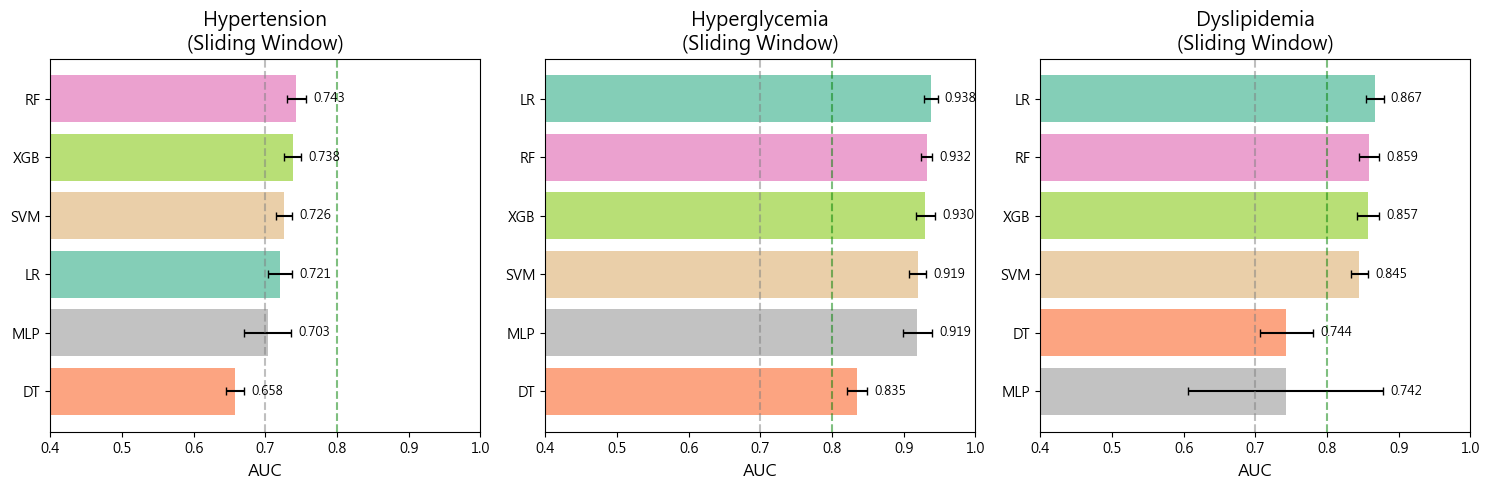


Saved: results/sliding_window_auc_comparison.png


In [11]:
# Visualization: AUC comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

diseases = list(targets.keys())
model_names = list(get_models().keys())
colors = plt.cm.Set2(np.linspace(0, 1, len(model_names)))

for idx, disease in enumerate(diseases):
    ax = axes[idx]
    disease_data = results_df[results_df['Disease'] == disease].sort_values('AUC', ascending=True)
    
    y_pos = np.arange(len(disease_data))
    bars = ax.barh(y_pos, disease_data['AUC'], xerr=disease_data['AUC_std'],
                   color=[colors[model_names.index(m)] for m in disease_data['Model']],
                   capsize=3, alpha=0.8)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(disease_data['Model'])
    ax.set_xlabel('AUC', fontsize=12)
    ax.set_title(f'{disease}\n(Sliding Window)', fontsize=14)
    ax.set_xlim(0.4, 1.0)
    ax.axvline(x=0.7, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0.8, color='green', linestyle='--', alpha=0.5)
    
    for i, (v, s) in enumerate(zip(disease_data['AUC'], disease_data['AUC_std'])):
        ax.text(v + s + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../../results/sliding_window_auc_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: results/sliding_window_auc_comparison.png")